# Approach 1

In [38]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

## Load the dataset

In [39]:
masked_files = [img for img in glob.glob("dataset/first_approach/with_mask/*.jpg")]
unmasked_files = [img for img in glob.glob("dataset/first_approach/without_mask/*.jpg")]
incorrect_files = [img for img in glob.glob("dataset/first_approach/incorrect_mask/*.jpg")]
masked = [cv.imread(img) for img in masked_files if cv.imread(img) is not None]
unmasked = [cv.imread(img) for img in unmasked_files if cv.imread(img) is not None]
incorrect = [cv.imread(img) for img in incorrect_files if cv.imread(img) is not None]

## See exemplary images

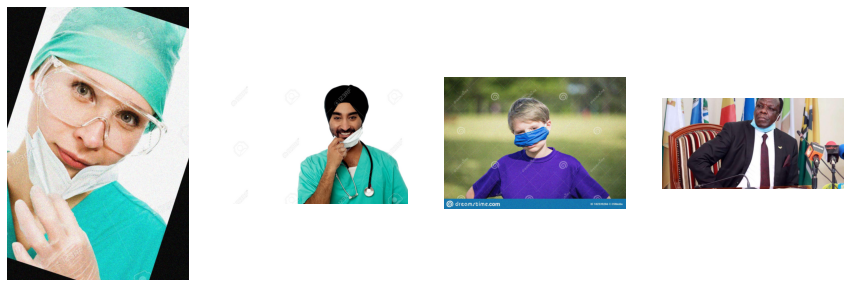

In [21]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(incorrect[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

That is not good. The images have watermarks and may be rotated.

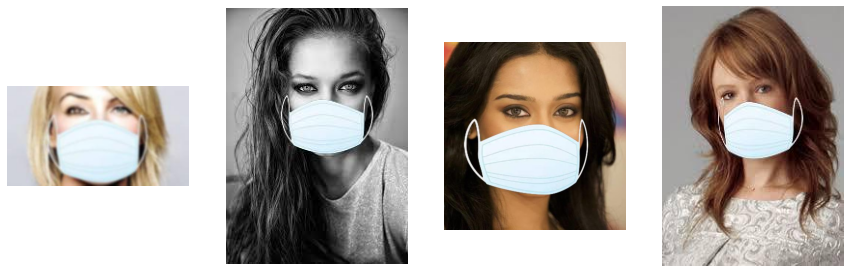

In [22]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(masked[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

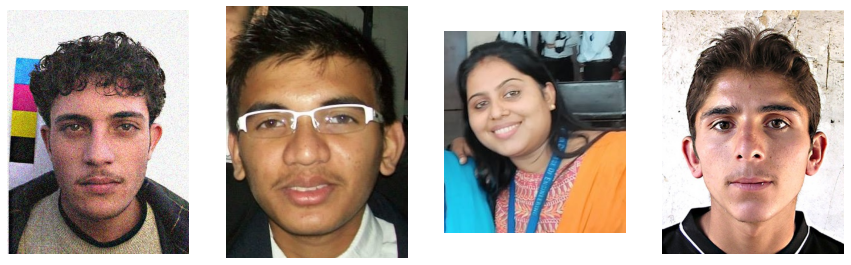

In [23]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(unmasked[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

## Detect faces

In this implementation I will use OpenCV's Haar Cascades.

In [32]:
face_detector = cv.CascadeClassifier('models/haarcascade_frontalface_default.xml')

To use this model, I have to convert my images into the greyscale.

The detector may detect multiple faces in the picture. I shall use them all in the next steps.

In [49]:
show_detected = [unmasked[0], masked[0], incorrect[0], unmasked[1], masked[1], incorrect[1]]

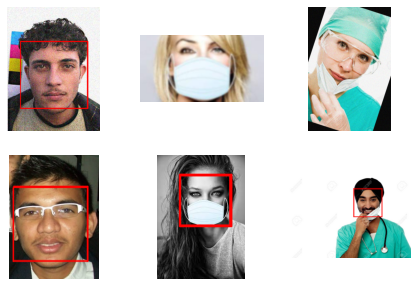

In [60]:
fig=plt.figure(figsize=(7.5, 5))
axes = []
for i in range(len(show_detected)):
    img_display = show_detected[i]
    img = cv.cvtColor(img_display, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img, scaleFactor = 1.2, minNeighbors = 5)
    for (a, b, c, d) in faces:
        cv.rectangle(img_display, (a, b), (a+c, b+d), (0, 0, 255), 2)
    img = cv.cvtColor(img_display, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(2, 3, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

In [57]:
print(len(masked))
print(len(unmasked))
print(len(incorrect))

690
686
685


The detected faces could be of different sizes - I need to rescale them before feeding them into another classifier.

In [61]:
def get_faces(img, model, scaleFactor=1.2, 
              minNeighbors=5, dimensions=(240, 240), for_display=False):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = model.detectMultiScale(img_gray, scaleFactor = scaleFactor, 
                                   minNeighbors = minNeighbors)
    extracted = []
    coords = []
    for (a, b, c, d) in faces:
        crop_img = img_gray[b:b+d, a:a+c]
        if crop_img.size != 0 and crop_img.size != 1:
            crop_img = cv.resize(crop_img, dimensions)
            extracted.append(crop_img)
    if len(extracted) == 0:
        return None
    if for_display:
        return extracted, faces
    return extracted

In [77]:
mfaces = [get_faces(image, face_detector, 1.2, 5) for image in masked]
mfaces = [face for image in mfaces if image is not None for face in image]

ufaces = [get_faces(image, face_detector, 1.2, 5) for image in unmasked]
ufaces = [face for image in ufaces if image is not None for face in image]

ifaces = [get_faces(image, face_detector, 1.2, 5) for image in incorrect]
ifaces = [face for image in ifaces if image is not None for face in image]

In [78]:
print(len(mfaces))
print(len(ufaces))
print(len(ifaces))

297
606
421


As we can see, the used face detector didn't work very well. It will most definitely hinder model's overall performance.

I should prepare the labels for the data.

In [85]:
mfaces_lbl = [2]* len(mfaces)
ifaces_lbl = [1]* len(ifaces)
ufaces_lbl = [0]* len(ufaces)
y = mfaces_lbl + ifaces_lbl + ufaces_lbl

In [102]:
 x= np.concatenate((mfaces, ifaces, ufaces))

And flatten the data for the classifier.

In [104]:
x = (np.array(x)).reshape(len(y), -1)

In [ ]:
from sklearn.model_selection import train_test_split